In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer

# Fitting of quantum many-body dynamics

Simulation of the dynamics of a 10-spin system under the fully connected transverse Ising Hamiltonian. The following code attempts to simulate the partial dynamics of the 10-spin system using a six qubit circuit.


### Generation of teaching data

Then, we must generate teaching data to be used. In order to do this, we apply the hamiltonian given by:

$H = \sum\limits^N_{j=1} a_j X_j + \sum\limits^N_{j=1}\sum\limits^{j-1}_{k=1} J_{jk}Z_jZ_k$

corresponding to the transverse Ising Hamiltonian. Coefficients $a_j$ and $J_{jk}$ are randomly set.

The dynamics started from the initialized state $\ket{0}^{\otimes 10}$. The transient at the beginning of evolution is discarded for the duration $T_{transient} = 300$. For practical use, one can employ the dynamics obtained experimentally from a quantum system with an unknown Hamiltonian as teacher data. 

In [2]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)
np.random.seed(2541)

## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)


In [3]:
# times 
x_times = np.linspace(-1,1,100)
n_system = 10
t_transition = 300
times = 4*(x_times+1)+t_transition



In [4]:
# Define observables to be measured
from qulacs import Observable

z0 = Observable(n_system)
z0.add_operator(1.,'Z 0') # a = 1

z1 = Observable(n_system)
z1.add_operator(1.,'Z 1') # a = 1

z2 = Observable(n_system)
z2.add_operator(1.,'Z 2') # a = 1

In [5]:
from qulacs.gate import DenseMatrix

#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian

ham = np.zeros((2**n_system,2**n_system), dtype = complex)
for i in range(n_system): ## i runs 0 to n_system-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], n_system)
    for j in range(i+1, n_system):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], n_system)

diag, eigen_vecs = np.linalg.eigh(ham)

z0_train_results = np.asarray([])
z1_train_results= np.asarray([])
z2_train_results = np.asarray([])


## Time evolution
for time_step in times:
    ## Define quantum state
    state = QuantumState(n_system)
    state.set_zero_state()
    ## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger

    time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT
    time_evol_gate = DenseMatrix([i for i in range(n_system)], time_evol_op)

    # Apply time evolution operator

    time_evol_gate.update_quantum_state(state)

    z0_val = z0.get_expectation_value(state)
    z0_noise = np.random.normal(0, (z0_val**2)*0.1)
    z0_train_results = np.append(z0_train_results, z0_val+z0_noise)
    z1_val = z1.get_expectation_value(state)
    z1_noise = np.random.normal(0, (z1_val**2)*0.1)
    z1_train_results= np.append(z1_train_results,z1_val+z1_noise)
    z2_val = z2.get_expectation_value(state)
    z2_noise = np.random.normal(0, (z2_val**2)*0.1)
    z2_train_results = np.append(z2_train_results, z2_val+z2_noise)

train_results = [np.asarray([z0_train_results[i], z1_train_results[i], z2_train_results[i]]) for i in range(len(z0_train_results))]
print(train_results)



[array([0.13944717, 0.12797941, 0.02702748]), array([0.14427099, 0.1315632 , 0.02412322]), array([0.14701143, 0.13303033, 0.02128747]), array([0.14309522, 0.13538416, 0.01829355]), array([0.14473092, 0.13205789, 0.01507323]), array([0.14340518, 0.13571795, 0.01173843]), array([0.13738133, 0.13653091, 0.00824469]), array([0.13316357, 0.13486768, 0.00467601]), array([0.13442084, 0.13650158, 0.0011522 ]), array([ 0.13429428,  0.13986393, -0.00217931]), array([ 0.13218946,  0.13666028, -0.00516821]), array([ 0.13153055,  0.13740932, -0.00763807]), array([ 0.1354156 ,  0.14046388, -0.00945015]), array([ 0.13777694,  0.13928473, -0.01044194]), array([ 0.13978924,  0.14370341, -0.01052992]), array([ 0.14487747,  0.13808513, -0.00968732]), array([ 0.14670073,  0.14180808, -0.00803836]), array([ 0.15174515,  0.14283522, -0.00576033]), array([ 0.15034422,  0.14116664, -0.00312671]), array([ 0.14874537,  0.1463164 , -0.00047494]), array([0.14498384, 0.14572209, 0.00185463]), array([0.1445607 , 0.

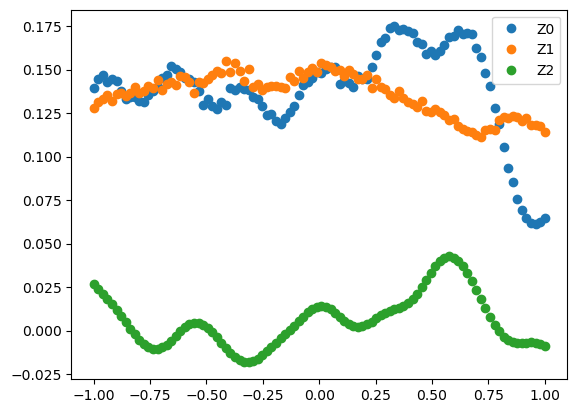

In [6]:
plt.plot(x_times, z0_train_results,'o', label = 'Z0')
plt.plot(x_times, z1_train_results, 'o',label = 'Z1')
plt.plot(x_times, z2_train_results, 'o',label = 'Z2')
plt.legend()

Now, we generate the quantum circuit for approximation

In [7]:
########  Parameter  #############
nqubit = 6 ## number of qubit
c_depth = 6 ## depth of circuit
time_step = 300 ## elapsed time of time evolution with random Hamiltonian

As in the previous exampples we will need to encode the input x parametrizing time in this case. So we create the gate $U_{in}(x_i)$ for embedding the input value $x_i$ in the initial state $\ket{00...0}$. According to reference $[1]$ we define:
$U_{in}(x_i) = $
with rotation gates
$R^Y_j$

So input $x_i$, is converted into: $\ket{\psi_{in}(x_i)} = U_{in}(x_i)\ket{00...0}$


[-2.97710295e-02-9.92053378e-01j  4.97397360e-02-9.94943968e-04j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+1.35525272e-20j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+1.35525272e-20j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04-1.35525272e-20j
 -1.25000000e-04-1.35525272e-20j  6.26570362e-08-6.26539032e-06j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+2.71050543e-20j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04-2.71050543e-20j
 -1.25000000e-04-2.71050543e-20j  6.26570362e-08-6.26539032e-06j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+0.00000000e+00j
 -1.25000000e-04+0.00000000e+00j  6.26570362e-08-6.26539032e-06j
 -1.25000000e-04+0.00000000e+00j  6.26570362e-08-6.26539032e-06j
  6.26570362e-08-6.265390

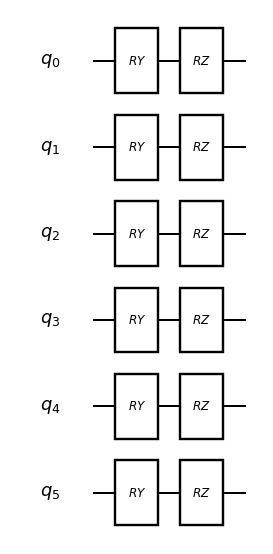

In [8]:
# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

circuit_drawer(U_in(x),'mpl')

With the input value codificated into the quantum state, we construct the variational quantum circuit in the same way that we did for the one dimensional fit of $\sin(x)$

In [9]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)



#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

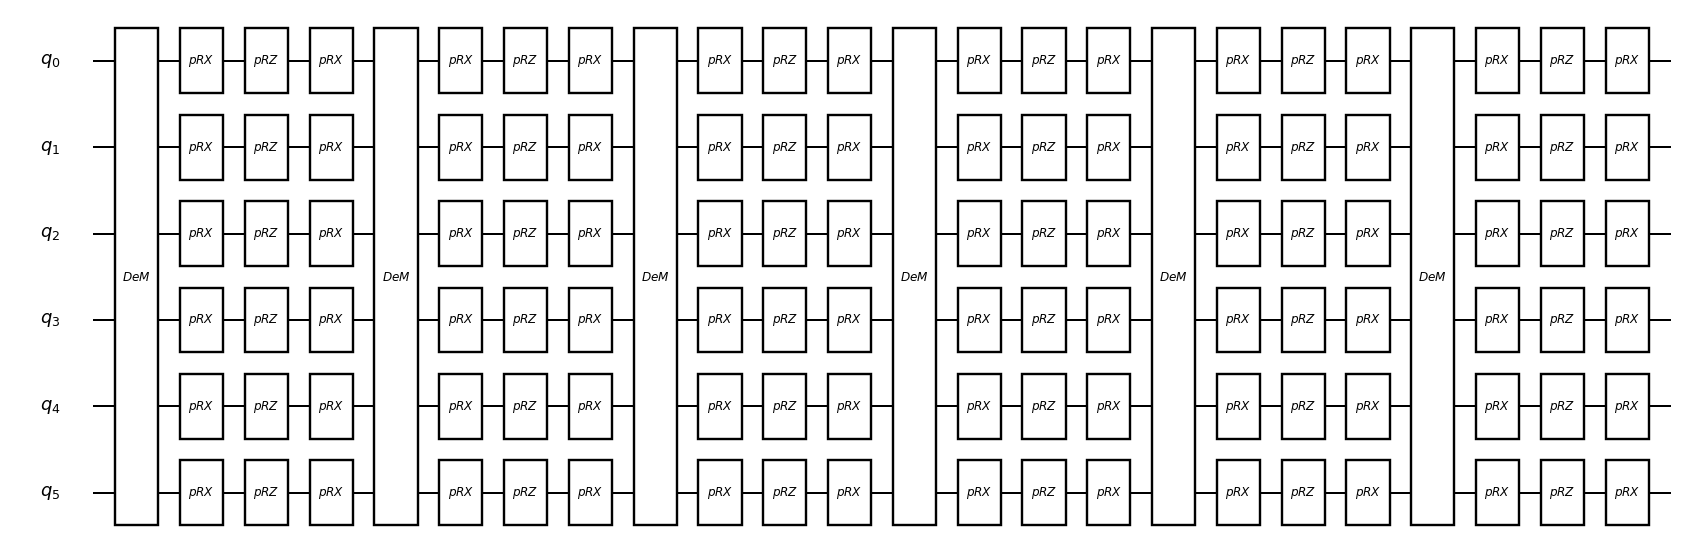

In [10]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')

In [11]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

### Measurement

We now define the operators to measure the expectation values of the circuit qubits

In [12]:
z0 = Observable(nqubit)
z0.add_operator(1.,'Z 0') # a = 1

z1 = Observable(nqubit)
z1.add_operator(1.,'Z 1') # a = 1

z2 = Observable(nqubit)
z2.add_operator(1.,'Z 2') # a = 1

def get_output(state):

    z0_val = z0.get_expectation_value(state)
    z1_val = z1.get_expectation_value(state)
    z2_val = z2.get_expectation_value(state)

    
    return np.asarray([z0_val, z1_val, z2_val])

In [13]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = get_output(state)

    return res

In [14]:
def quadratic_loss(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

In [15]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_times]

    # quadratic loss
    L = quadratic_loss(train_results, y_pred)

    return L

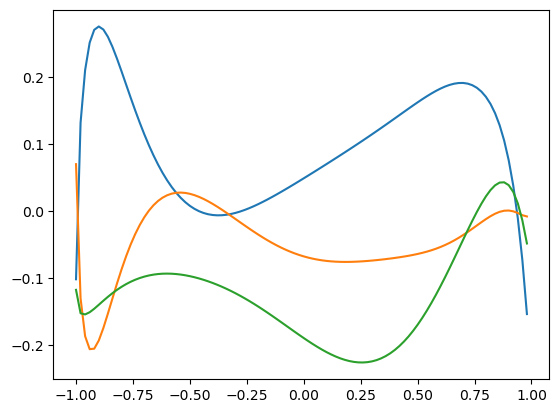

In [16]:
# Figure basing on inital parameter theta
xlist = np.arange(-1, 1, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [17]:
from scipy.optimize import minimize
result = minimize(cost_func, theta_init, method='BFGS')

In [ ]:
# Solution of theta by optimization
theta_opt = result.x
print(theta_opt)

[ 4.1771501   2.04380976  0.22329335  5.32939335  3.19858375  1.31074164
  0.58345338  5.48758224  0.80418613  3.58202382  1.22527932  0.93135278
  5.97265027  3.91868661  1.48626482  3.11790013  5.38285789  4.97899943
  2.4437628   1.74091316  4.48956131  5.25669501  4.54919042  2.49165267
  3.58219196  6.11187367  3.66809753  3.29784768  0.57050216  0.23782478
  5.58015019  1.37557538  3.27252697  4.06126159  3.9897495   4.35983086
  0.78115507  3.18213609  3.5961523   0.07226582  1.27932069  3.58325873
  0.94375596  2.27692735  2.73069475  5.2991128   4.41016872  4.85052881
  1.71584476  3.55361215  1.65286883  5.15469977  1.56857888  0.35997794
  2.90349033 -0.07826503  6.05764339  5.90372753  4.79390188  5.30716291
  0.47869089  5.07578039  5.52791212  4.49382159  3.47643939  2.17395883
  1.79027082  1.2635369   4.01140161  5.48403401  6.07656499  1.18043312
  4.7173663   4.31201444  3.78849925  3.98229982  6.16876235 -0.08717966
  0.00733024  4.30441611  6.05339305  2.16504817  1

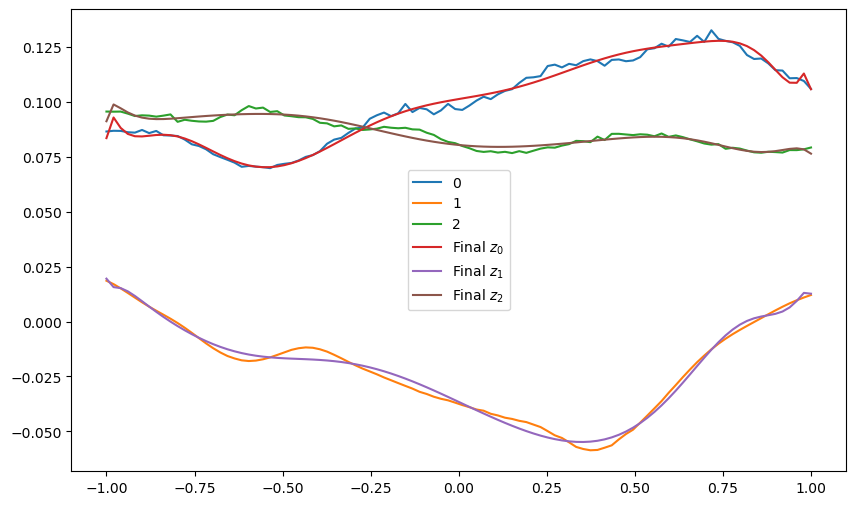

In [ ]:
# Insert optimized theta into U_out
set_U_out(theta_opt)
# Plot
plt.figure(figsize=(10, 6))

xlist = np.linspace(-1, 1,100)

# teacher data
plt.plot(x_times, train_results,  label=['0','1','2'])



# Figure basing on inital parameter theta
#plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# Prediction of the model
z0_predictions = np.array([qcl_pred(x, U_out)[0] for x in xlist])
z1_predictions = np.array([qcl_pred(x, U_out)[1] for x in xlist])
z2_predictions = np.array([qcl_pred(x, U_out)[2] for x in xlist])

plt.plot(xlist, z0_predictions, label='Final $z_0$')
plt.plot(xlist, z1_predictions, label='Final $z_1$')
plt.plot(xlist, z2_predictions, label='Final $z_2$')


plt.legend()
plt.show()